# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 10
oce_val = 0
gamma =3e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

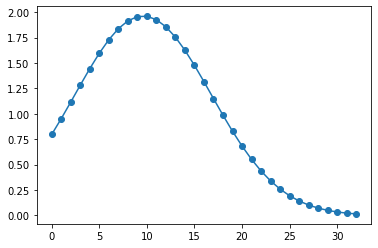

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

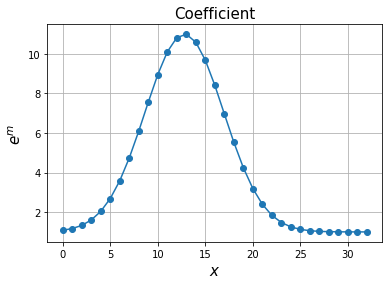

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

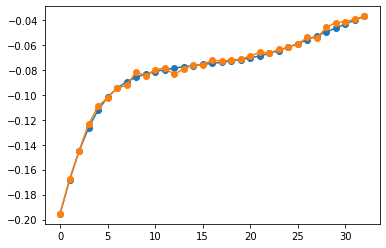

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [8]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print('left side: ',(u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[0]) )
print('right side: ',(u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(m.compute_vertex_values()[-1]) )
print('true left side: ', u0L)
print('true right side: ', u0R)

left side:  0.974941164642372
right side:  0.10007059749561598
true left side:  1.0
true right side:  0.1


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plot Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


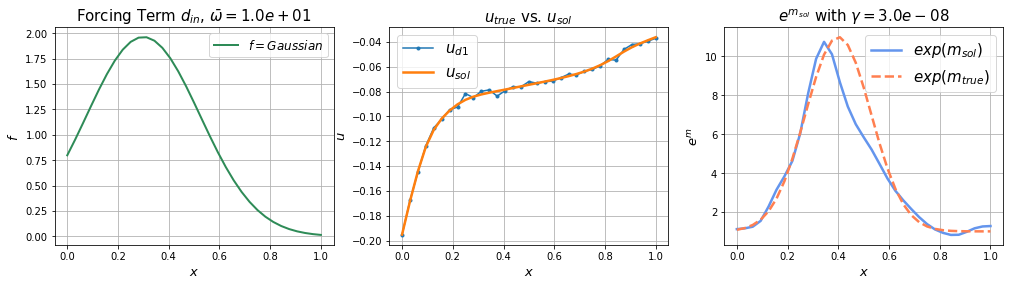

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_NB_synth.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [1]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt


## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

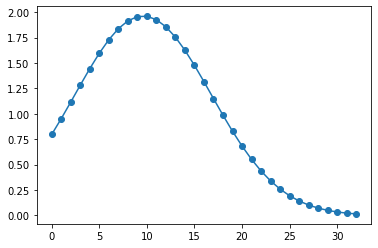

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 0.0#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 1.0


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

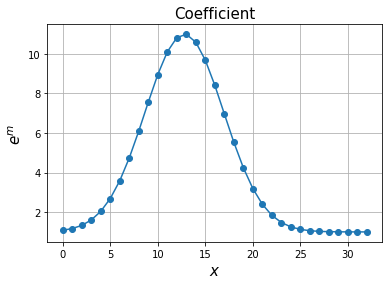

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

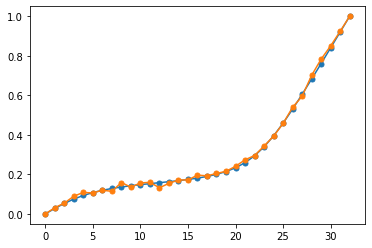

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

0.0
1.0


## Optimization Loop

In [8]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.75362e-03   3.48909e-03   1.81405e-05   1.15103e-01   3.37827e-02   1.00e+00   5.000e-01
 2     2     7.85145e-04   1.40428e-03   1.66010e-04   4.57876e-02   8.44484e-03   1.00e+00   5.000e-01
 3     1     6.64292e-04   1.17679e-03   1.51790e-04   1.54948e-02   5.52185e-03   1.00e+00   4.043e-01
 4     2     3.56893e-04   3.03443e-04   4.10344e-04   2.50671e-02   2.80898e-03   1.00e+00   2.884e-01
 5     2     3.43724e-04   2.66141e-04   4.21306e-04   5.03947e-03   9.47733e-04   1.00e+00   1.675e-01
 6     4     3.32006e-04   2.11172e-04   4.52840e-04   4.84633e-03   4.08099e-04   1.00e+00   1.099e-01
 7     4     3.31946e-04   2.13801e-04   4.50091e-04   3.36969e-04   3.73623e-05   1.00e+00   3.326e-02
 8     5     3.31943e-04   2.13476e-04   4.50409e-04   7.92547e-05   8.92979e-06   1.00e+00   1.626e-02
 9     7     3.31942e-04   2.13432e-04   4.50453e-04   5.64288e-06   7.

## Plotting Results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


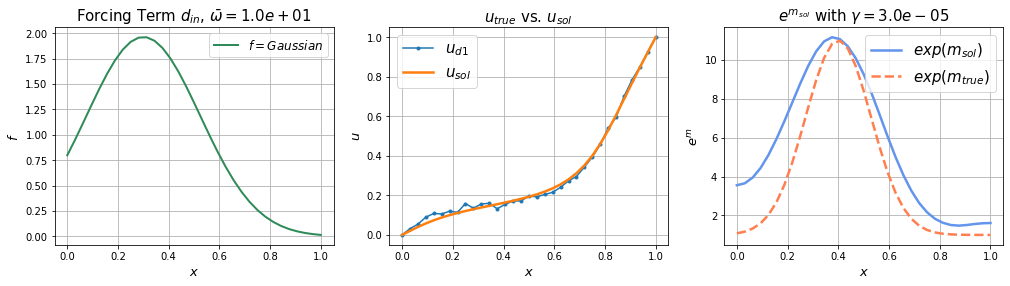

In [11]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

# Dual Data Problem

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

## Initialization

In [30]:
nx = 32
a,b = 0,1
omega = 10
oce_val1 = 0.0
oce_val2 = 0.0
gamma =3e-8

beta1 = 0.0
beta2 = 1.0

run = dual_data_run(nx, a, b, gamma, omega, omega, oce_val1, oce_val2, normalized_mean1=oce_val1,normalized_mean2=oce_val2, beta1=beta1, beta2 = beta2)
x = run.mesh.coordinates()

In [31]:
a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str,a1_adj_str, L1_adj_str,  a2_state_str, L2_state_str,  a2_adj_str, L2_adj_str)

## Forcing Term

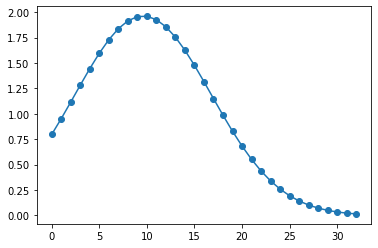

In [32]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [33]:
from numpy import cos, pi, sin, exp
u1L_D = 0.0#cos(0.0)*3*pi
u1R_D = 1.0 #cos(3*pi)*3*pi
u2L_N = 1.0
u2R_N = 0.1
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D}, NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: 1.0, NBC_L: 1.0, NBC_R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

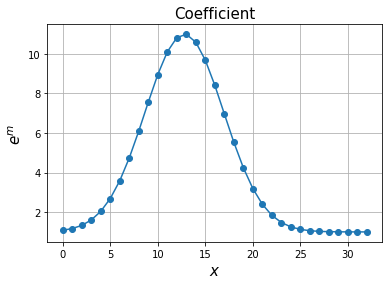

In [34]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)
run.mtrue_setup(mtrue)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

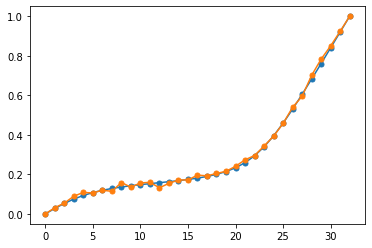

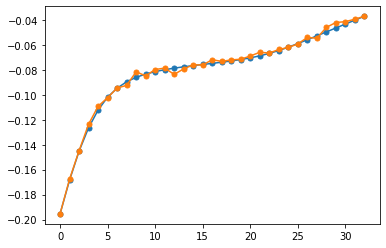

In [35]:

noise_level = 0.01
ud1, ud2, goal_A1, goal_b1, goal_A2, goal_b2 = run.fwd_solve(m)
utrue1_array = ud1.compute_vertex_values()
utrue2_array = ud2.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud1, goal_A1)
np.random.seed(0)
apply_noise(noise_level, ud2, goal_A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(),normalize=False)

plt.plot(utrue1_array, 'o-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(utrue2_array, 'o-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [36]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)
print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

0.0
1.0
0.487470582321186
0.05003529874780799


## Optimization Loop

In [37]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y%m%d-%H%M%S")
print(dt_string)

20230906-132253


In [38]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plotting Results

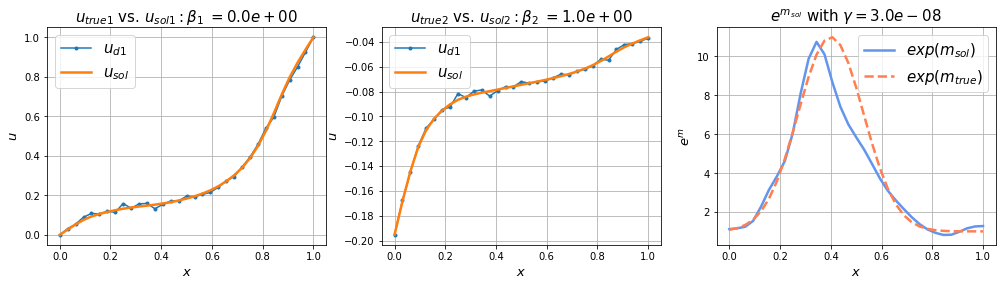

In [39]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

# Construct a Dual Problem

## single data DBC or NBC

In [1]:
from helm_eq import single_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [15]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 1.0
oce_val = 1.0
gamma =1e-5
run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=0.0)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

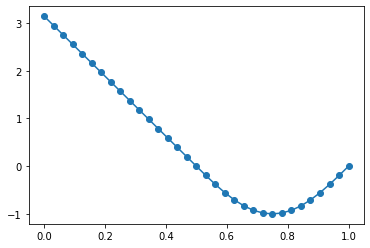

In [16]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()
if bc_type == 'DBC':
    y1[x>=0.5] = y_lin[x>=0.5]
elif bc_type == 'NBC':
    y1[x<=0.5] = y_lin[x<=0.5]
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
dy1 = np.gradient(y1,x,edge_order=2)

# plt.plot(x, np.gradient(y1,x), 'o')
plt.plot(x, y1, 'o-')
# plt.plot(x, dy1)
# plt.plot(x, cos(x*pi*2)* 2 * pi)
# plt.plot(x, y2, 'o')
# plt.plot(x,y_lin)

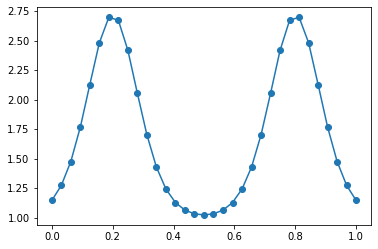

In [17]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


### Setup Forcing

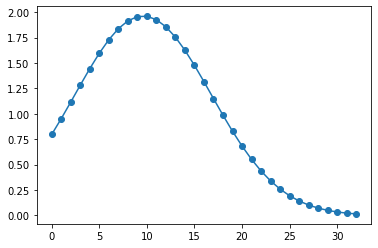

In [18]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

### Setup BC

In [19]:
uL = y1[0] if bc_type == 'DBC' else dy1[0] * np.exp(mtrue_array[0])
uR = y1[-1] if bc_type == 'DBC' else dy1[-1] * np.exp(mtrue_array[-1])
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: -7.193748245861232, uR: 7.284953059937024


### Set up extra Forcing

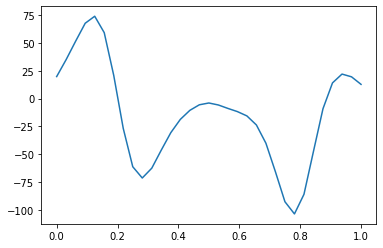

In [20]:
g_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g = dl.Function(run.Vu)
g.vector().set_local(g_array[::-1])
run.extra_f_setup(g = g)

plt.plot(x,run.g.compute_vertex_values())
plt.show()

### Setup Data


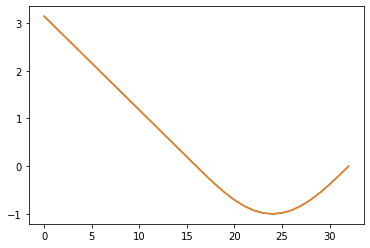

In [21]:
run.data_setup(ud_array=y1,normalize=False)
plt.plot(run.ud.compute_vertex_values())
plt.plot(y1)

### Initial Guess

-4.327331869120914
4.304740217197435
-7.193748245861232 7.284953059937024


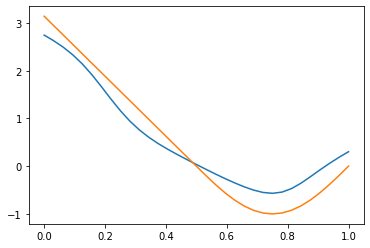

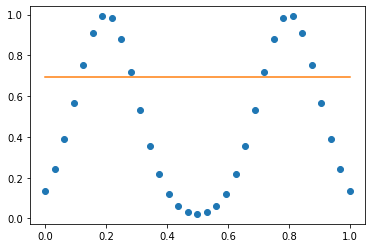

In [24]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    print(y1[0], y1[-1])
elif bc_type == 'NBC':
    print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
    print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    print(uL, uR)

plt.plot(x,u.compute_vertex_values())
plt.plot(x,run.ud.compute_vertex_values())
plt.show()

plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

### Optimization Loop

In [25]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.54925e-02   5.09849e-02   1.91529e-08   2.39558e-01   4.14901e-01   1.00e+00   5.000e-01
 2     2     1.21562e-02   2.43027e-02   9.66593e-06   1.48533e-01   1.59749e-01   1.00e+00   5.000e-01
 3     2     1.13369e-02   2.26575e-02   1.61733e-05   4.26500e-02   3.77024e-02   1.00e+00   3.014e-01
 4     7     1.01764e-02   2.02938e-02   5.89608e-05   4.58434e-02   1.47910e-02   1.00e+00   1.888e-01
 5     1     1.01148e-02   2.01706e-02   5.89482e-05   1.11476e-02   2.16548e-02   1.00e+00   2.285e-01
 6    14     9.95761e-03   1.98070e-02   1.08211e-04   2.35125e-02   4.02421e-03   5.00e-01   9.848e-02
 7     2     9.95505e-03   1.98015e-02   1.08612e-04   2.24284e-03   1.97802e-03   1.00e+00   6.905e-02
 8    19     9.93778e-03   1.97663e-02   1.09265e-04   5.81248e-03   1.29663e-03   1.00e+00   5.590e-02
 9     2     9.93770e-03   1.97661e-02   1.09309e-04   3.99086e-04   5.

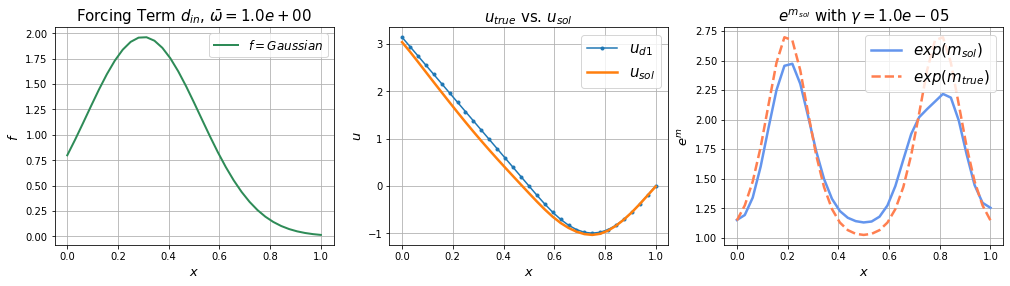

In [26]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
plt.show()

## Double Data 

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt

In [33]:
nx = 32
a,b = 0,1
omega = 1.0
oce_val = 1.0
beta1 = 0.5
beta2 = 0.5
gamma =np.exp(beta1 * np.log(1.842e-5) + beta2 * np.log(2.330e-5))
print(f'gamma  = {gamma}')
run = dual_data_run(nx,a,b,gamma,omega,omega,oce_val,oce_val, normalized_mean1=0.0, normalized_mean2=0.0, beta1=beta1, beta2=beta2)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma  = 2.0716804772937326e-05
Calling FFC just-in-time (JIT) compiler, this may take some time.


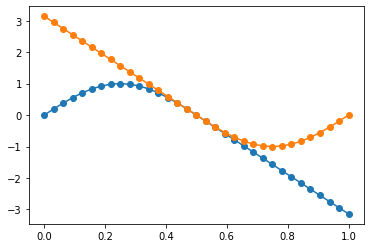

In [34]:
from numpy import cos, sin, exp, pi
x = np.linspace(a,b,nx+1)

y = sin(2* pi * x)
y_lin = -2 * pi * x +  pi
y1 = y.copy()
y2 = y.copy()

y1[x>=0.5] = y_lin[x>=0.5]
y2[x<=0.5] = y_lin[x<=0.5]
    
dy1 = np.gradient(y1,x,edge_order=2)
dy2 = np.gradient(y2,x,edge_order=2)

plt.plot(x, y1, 'o-')
plt.plot(x, y2, 'o-')

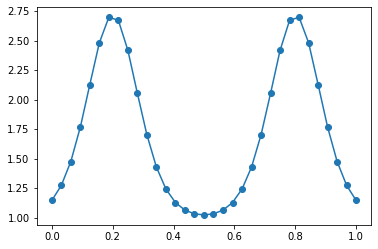

In [35]:
def gaussian(x, mean, std):
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(std, 2.)))

mtrue_array = gaussian(x, 0.2, 0.1) + gaussian(x, 0.8, 0.1)
# mtrue_array = np.log(1 + 10 * gaussian(x, 0.4, 1/np.sqrt(60)))
# mtrue_array = np.zeros_like(x)
m_true = dl.Function(run.Vm)
m_true.vector().set_local(mtrue_array[::-1])
run.mtrue_setup(m_true)
plt.plot(x, np.exp(run.mtrue.compute_vertex_values()), 'o-')


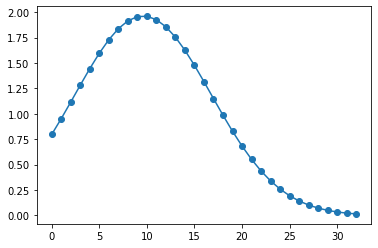

In [36]:

from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

In [37]:
from numpy import cos, pi, sin, exp
u1L_D = y1[0]
u1R_D = y1[-1]
u2L_N = dy2[0] * np.exp(mtrue_array[0])
u2R_N = dy2[-1] * np.exp(mtrue_array[-1])
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: -3.141592653589793,
NBC_L: -7.193748245861232, NBC_R: 7.284953059937024


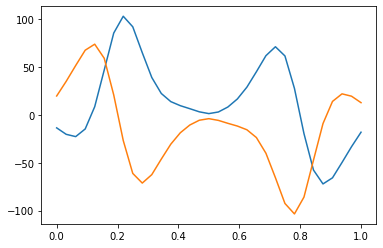

In [38]:
g1_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y1, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y1 - oce_val)

g1 = dl.Function(run.Vu)
g1.vector().set_local(g1_array[::-1])

g2_array = - np.gradient( np.exp(mtrue_array) * np.gradient(y2, x, edge_order=2) , x, edge_order=2) \
            + forcing_array * omega * (y2 - oce_val)
g2 = dl.Function(run.Vu)
g2.vector().set_local(g2_array[::-1])
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values())
plt.plot(x,run.g2.compute_vertex_values())
plt.show()

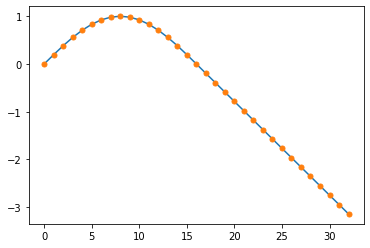

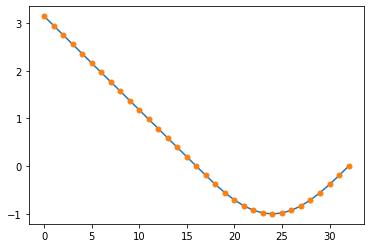

In [39]:

run.data_setup(y1, y2 ,normalize=False)

plt.plot(y1, '-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o',markersize=5)
plt.show()
plt.plot(y2, '-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o',markersize=5)
plt.show()

0.0
-3.141592653589793
-3.779591263149001
3.7598591943332496


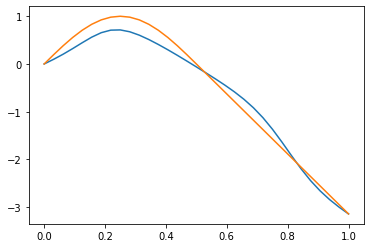

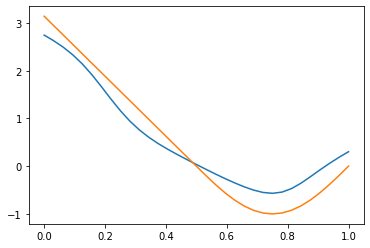

In [40]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)

print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

plt.plot(x, u1.compute_vertex_values())
plt.plot(x, run.ud1.compute_vertex_values())
plt.show()

plt.plot(x, u2.compute_vertex_values())
plt.plot(x, run.ud2.compute_vertex_values())

In [41]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.45959e-02   6.91918e-02   5.88135e-08   2.26459e-01   2.51512e-01   1.00e+00   5.000e-01
 2     1     3.22606e-02   6.45211e-02   1.80935e-07   2.22179e-01   3.13392e-01   1.00e+00   5.000e-01
 3     1     2.89535e-02   5.79066e-02   3.88014e-07   1.90643e-01   2.16919e-01   1.00e+00   5.000e-01
 4     1     2.76976e-02   5.53946e-02   5.94422e-07   1.92411e-01   2.67368e-01   1.00e+00   5.000e-01
 5     1     2.56474e-02   5.12940e-02   8.71328e-07   1.70848e-01   1.92551e-01   1.00e+00   5.000e-01
 6     1     2.28297e-02   4.56584e-02   1.08254e-06   1.66819e-01   2.37930e-01   1.00e+00   5.000e-01
 7     1     1.79506e-02   3.58999e-02   1.27325e-06   1.51747e-01   1.62286e-01   5.00e-01   5.000e-01
 8     2     1.44613e-02   2.89164e-02   6.29194e-06   1.20567e-01   1.39137e-01   5.00e-01   5.000e-01
 9     3     9.68878e-03   1.93453e-02   3.23107e-05   1.35330e-01   8.

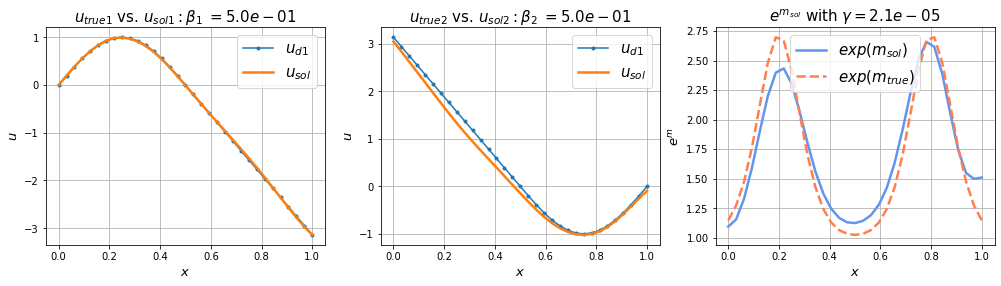

In [47]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true1}$ vs. $u_{sol1}: \beta_1$' + f' $ = {beta1:1.1e}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true2}$ vs. $u_{sol2}: \beta_2$' + f' $ = {beta2:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./log/img/dual_helm_synth_{beta1:1.1f}_{beta2:1.1f}.eps', format='eps',dpi=250)
plt.show()

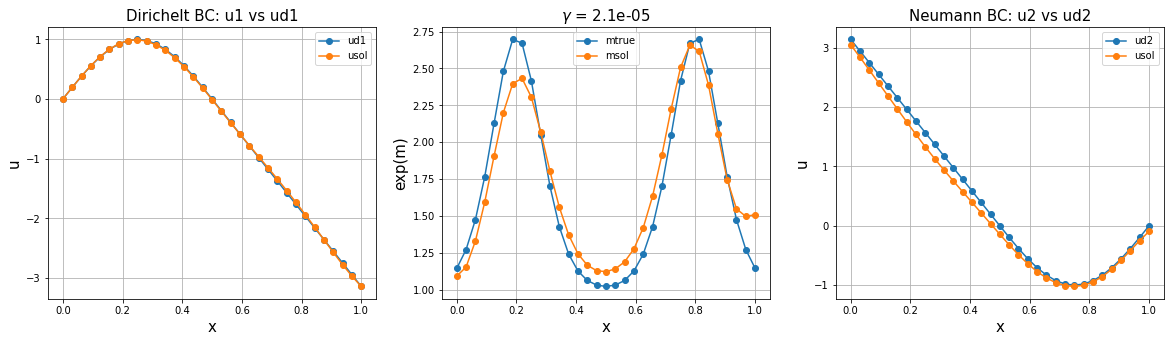

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5)) 
ax[0].plot(x,run.ud1.compute_vertex_values(), 'o-', label='ud1')
ax[0].plot(x,u1.compute_vertex_values(), 'o-', label='usol')
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('u', fontsize=15)
ax[0].set_title('Dirichelt BC: u1 vs ud1', fontsize=15)
ax[0].grid()
ax[0].legend()

ax[1].plot(x,np.exp(m_true.compute_vertex_values()), 'o-', label='mtrue')
ax[1].plot(x,np.exp(m.compute_vertex_values()), 'o-', label='msol')
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('exp(m)', fontsize=15)
ax[1].set_title(f'$\gamma$ = {gamma:1.1e}', fontsize=15)
ax[1].grid()
ax[1].legend()

ax[2].plot(x,run.ud2.compute_vertex_values(), 'o-', label='ud2')
ax[2].plot(x,u2.compute_vertex_values(), 'o-', label='usol')
ax[2].set_xlabel('x', fontsize=15)
ax[2].set_ylabel('u', fontsize=15)
ax[2].set_title('Neumann BC: u2 vs ud2', fontsize=15)
ax[2].grid()
ax[2].legend()